Data directory: visu_sets
Found 1784 images belonging to 2 classes.
Found 445 images belonging to 2 classes.
Class indices: {'engine': 0, 'fishing': 1}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 510, 510, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 255, 255, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 253, 253, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 

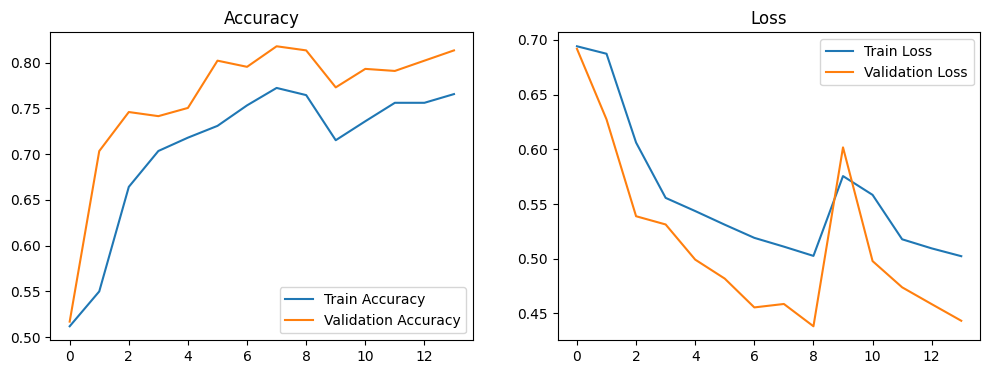

56/56 [==============================] - 24s 421ms/step - loss: 0.4383 - accuracy: 0.8135
Evaluation Results - Loss: 0.43829914927482605, Accuracy: 0.8134831190109253


In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Attention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Set paths
data_dir = "visu_sets"

# Parameters
img_height = 512
img_width = 512
batch_size = 8
num_classes = 2

# Debugging: Check directory structure
print(f"Data directory: {data_dir}")

# Data Augmentation and Preprocessing
data_gen = ImageDataGenerator(
    rescale=1.0/255.0, 
    validation_split=0.2
)

train_data = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_data = data_gen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Debugging: Check class indices
print(f"Class indices: {train_data.class_indices}")

# Model Architecture
model = Sequential([
    # Start with a couple of convolutional layers to extract feature maps
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Add a dilated convolution layer to capture larger context
    Conv2D(64, (3, 3), dilation_rate=(2, 2), activation='relu'),
    MaxPooling2D((2, 2)),

    # Global Average Pooling to reduce spatial dimensions
    GlobalAveragePooling2D(),

    # Add a fully connected layer with a dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer with sigmoid if it's a binary classification (or change accordingly)
    Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Debugging: Print model summary
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

# Plot Training History
def plot_training(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_training(history)

# Save Final Model
model.save('final_model.h5')

# Debugging: Evaluate Model
def evaluate_model(model, data):
    loss, accuracy = model.evaluate(data)
    print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

evaluate_model(model, val_data)